# Juliaで精度保証付き高速フーリエ変換
データが $N$ 個の離散フーリエ変換 (DFT:discrete Fourier transform)

$\newcommand{\C}{\mathbb{C}}$

$$
X_{k}=\sum_{n=0}^{N-1} x_{n} W_{N}^{k n},\quad X\in\C^N
$$
に対する高速フーリエ変換(FFT:Fast Fourier Transform)の精度保証付き数値計算を考える。
FFTの起源は1965年のJ.W.Cooleyと J.W.Tukey による論文だとされている。(これははじめにに使う)

JuliaではFFTのライブラリとしては、FFTW.jlが準備されており、OCamlで最適なCのコードを自動生成する仕組みとなっている。

## 離散フーリエ変換(DFT)
$\newcommand{\C}{\mathbb{C}}$
データが $N$ 個の離散フーリエ変換を $X\in\C^N$ とした場合、以下のように書くことができる。

$$
\left(\begin{array}{c}
X_{0} \\
X_{1} \\
X_{2} \\
\vdots \\
X_{k-1}
\end{array}\right)=\left(\begin{array}{ccccc}
1 & 1 & 1 & \cdots & 1 \\
1 & e^{-i \frac{2 \pi}{N}} & e^{-i \frac{4 \pi}{N}} & \cdots & e^{-i \frac{2 \pi(N-1)}{N}} \\
1 & e^{-i \frac{4 \pi}{N}} & e^{-i \frac{8 \pi}{N}} & \cdots & e^{-i \frac{4 \pi(N-1)}{N}} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & e^{-i \frac{2 \pi(N-1)}{N}} & e^{-i \frac{4 \pi(N-1)}{N}} & \cdots & e^{-i \frac{2 \pi(N-1)(N-1)}{N}}
\end{array}\right)\left(\begin{array}{c}
x_{0} \\
x_{1} \\
x_{2} \\
\vdots \\
x_{n-1}
\end{array}\right)
$$

$W^n_N$は回転因子という。
$$
W^n_N = e^{-i \frac{2 \pi n}{N}} = \cos \left(\frac{2 \pi n}{N}\right)-i \sin \left(\frac{2 \pi n}{N}\right)
$$

これを用いると、

$$
\left(\begin{array}{c}
X_{0} \\
X_{1} \\
X_{2} \\
\vdots \\
X_{k-1}
\end{array}\right)=\left(\begin{array}{ccccc}
1 & 1 & 1 & \cdots & 1 \\
1 & W_{N} & W_{N}^{2} & \cdots & W_{N}^{N-1} \\
1 & W_{N}^{2} & W_{N}^{4} & \cdots & W_{N}^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & W_{N}^{(N-1)} & W_{N}^{2(N-1)} & \cdots & W_{N}^{(N-1)(N-1)}
\end{array}\right)\left(\begin{array}{c}
x_{0} \\
x_{1} \\
x_{2} \\
\vdots \\
x_{n-1}
\end{array}\right)
$$

$$
X_{k}=\sum_{n=0}^{N-1} x_{n} W_{N}^{k n}
$$

ただし、$0\leq k < n$である。

## 高速フーリエ変換(FFT)
FFTはDFTを高速に行うためのアルゴリズムである。DFTでは、 $X_0$ から $X_{N−1}$ の $N$ 回の計算を行うために、 $N^2$ 回複素数の四則演算を行う必要がある。しかし、データ数$N$が2の冪乗である場合、FFTを用いることで、この膨大な複素数の計算を$N \log N$に比例する回数に減らすことができる。

$$
\begin{array}{c}
X_{k}^{(0)}=\sum_{n=0}^{N / 2-1} W_{N / 2}^{n k} x_{2 n} \quad(0 \leq k<n / 2) \\
X_{k}^{(1)}=\sum_{n=0}^{N / 2-1} W_{N / 2}^{n k} x_{2 n+1} \quad(0 \leq k<n / 2) \\
\left\{\begin{array}{l}
X_{k}=X_{n}^{(0)}+W_{N}^{k} X_{n}^{(1)}, \\
X_{k+N / 2}=X_{n}^{(0)}-W_{N}^{k} X_{n}^{(1)} \quad(0 \leq k<n / 2)
\end{array}\right.
\end{array}
$$

この考え方を利用したものがCooley-Tukey FFTアルゴリズム(文献1)である。

## Cooley-Tukey FFTアルゴリズムの実装
Juliaを使ったCooley-Tukey FFTアルゴリズムでの精度保証付き数値計算の実装を行った。(https://github.com/JuliaApproximation/FastTransforms.jl/blob/4a076c9fbacfe5201124cfe3b1d7002dbb0a8c7b/src/fftBigFloat.jl#L11)

In [1]:
#Cooley-Tukey FFTアルゴリズム
function generic_fft_pow2!(x::Vector{T}) where T
    n,big2=length(x),2one(T)
    nn,j=n÷2,1
    for i=1:2:n-1
        if j>i
            x[j], x[i] = x[i], x[j]
            x[j+1], x[i+1] = x[i+1], x[j+1]
        end
        m = nn
        while m ≥ 2 && j > m
            j -= m
            m = m÷2
        end
        j += m
    end
    logn = 2
    while logn < n
        θ=-big2/logn
        wtemp = sinpi(θ/2)
        wpr, wpi = -2wtemp^2, sinpi(θ)
        wr, wi = one(T), zero(T)
        for m=1:2:logn-1
            for i=m:2logn:n
                j=i+logn
                mixr, mixi = wr*x[j]-wi*x[j+1], wr*x[j+1]+wi*x[j]
                x[j], x[j+1] = x[i]-mixr, x[i+1]-mixi
                x[i], x[i+1] = x[i]+mixr, x[i+1]+mixi
            end
            wr = (wtemp=wr)*wpr-wi*wpi+wr
            wi = wi*wpr+wtemp*wpi+wi
        end
        logn = logn << 1
    end
    return x
end

function interlace(a::Vector{S},b::Vector{V}) where {S,V}
    na=length(a);nb=length(b)
    T=promote_type(S,V)
    if nb≥na
        ret=zeros(T,2nb)
        ret[1:2:1+2*(na-1)]=a
        ret[2:2:end]=b
        ret
    else
        ret=zeros(T,2na-1)
        ret[1:2:end]=a
        if !isempty(b)
            ret[2:2:2+2*(nb-1)]=b
        end
        ret
    end
end

function generic_fft_pow2(x::Vector{Complex{T}}) where T
    y = interlace(real(x),imag(x))
    generic_fft_pow2!(y)
    return complex.(y[1:2:end],y[2:2:end])
end

generic_fft_pow2(x::Vector{T}) where {T} = generic_fft_pow2(complex(x))

# function generic_fft_pow2(x::Matrix{T}) where {T} 
#     row, col = size(x)
#     for i in 1:col
#         x[:,i] = generic_fft_pow2(complex(x[:,i]))
#     end
#     return x
# end

generic_fft_pow2 (generic function with 2 methods)

## Bluestein(Chirp z)アルゴリズム
https://www.dsprelated.com/freebooks/mdft/Bluestein_s_FFT_Algorithm.html


Cooley-Tukey FFTアルゴリズムでは、データ数$N$が2の冪乗である場合しか計算できないという問題がある。これを解決したのがBluestein(Chirp z)アルゴリズムである。任意のデータ数$N$のDFTを畳み込みに変形してFFTで計算する。
\begin{align*}
X_{k} &=\sum_{n=0}^{N-1} x_{n} W_{N}^{k n}\\
        &=\sum_{n=0}^{N-1} x_{n} W_{N}^{-\frac{(k-n)^{2}}{2}+\frac{k^{2}}{2}+\frac{n^{2}}{2}}\\
        &=W_{2 N}^{k^{2}} \sum_{n=0}^{N-1}\left\{x_n W_{2N}^{n^{2}}\right\} W_{2 N}^{-(k-n)^{2}}
\end{align*}
ここで、$\left\{\alpha_{n}\right\},\left\{\beta_{n}\right\}$を以下のように定め,$X_{k}$を書き換える。
$$
\begin{aligned}
\alpha_{n} &=x_n W_{2 N}^{n^{2}} \\
\beta_{n} &=W_{2 N}^{-n^{2}}\\
X_{k}&=\beta_{k}^{*} \sum_{n=0}^{N-1} \alpha_{n} \beta_{k-n}\\
&=\beta_{k}^{*}\left(\alpha_{k} * \beta_{k}\right)
\end{aligned}
$$
次に、FFTでこの畳み込み演算$ \alpha_{k} * \beta_{k} $を考える。
このときのFFTの長さ$ L $は、$\alpha_{n},\beta_{n}$の長さを$n_{u},n_{v}$とすれば、$ L $は$ L \leq n_{u}+ n_{v} - 1$を満たす最小の2の冪乗数を選ぶこととする。
これにより、$\alpha_{n},\beta_{n}$は、
$$
\alpha_{n}^{\prime}=\left\{\begin{array}{ll}
n & (0 \leq n<N) \\
0 & (N \leq n<L)
\end{array}\right.
$$

$$
\left\{\begin{aligned}
\beta_{0}^{\prime} &=\beta_{0}\quad(n=0) \\
\beta_{n}^{\prime}=\beta_{L-n}^{\prime} &=\beta_{n} \quad (0<n<N) \\
\beta_{n}^{\prime} &=0 \quad (N \leq n \leq L-N)
\end{aligned}\right.
$$

となる。FFTを用いて$\alpha_{n}^{\prime},\beta_{n}^{\prime}$を計算し、その値を逆フーリエ変換(IFFT:inverse fast Fourier transform)して出てくる値を$\gamma_{k}^{\prime}$とする。これが$ \alpha_{k} * \beta_{k} $となる。以上より、$ X_{k} $が求まる。

$$
X_{k}=\beta_{k}^{*} \gamma_{k}^{\prime}
$$



In [2]:
function Bluestein_fft(x::Vector{T}) where T
#     T <: FFTW.fftwNumber && (@warn("Using generic fft for FFTW number type."))
    n = length(x)
    ispow2(n) && return generic_fft_pow2(x)
    ks = range(zero(real(T)),stop=n-one(real(T)),length=n)
    Wks = exp.((-im).*convert(T,π).*ks.^2 ./ n)
    xq, wq = x.*Wks, conj([exp(-im*convert(T,π)*n);reverse(Wks);Wks[2:end]])
    return Wks.*conv(xq,wq)[n+1:2n]
end

function conv(u::StridedVector{T}, v::StridedVector{T}) where T
    nu,nv = length(u),length(v)
    n = nu + nv - 1
    np2 = nextpow(2,n)
    append!(u,zeros(T,np2-nu)),append!(v,zeros(T,np2-nv))
    y = generic_ifft_pow2(generic_fft_pow2(u).*generic_fft_pow2(v))
    #TODO This would not handle Dual/ComplexDual numbers correctly
    y = T<:Real ? real(y[1:n]) : y[1:n]
end

function generic_ifft_pow2(x::Vector{Complex{T}}) where T
    y = interlace(real(x),-imag(x))
    generic_fft_pow2!(y)
    return complex.(y[1:2:end],-y[2:2:end])/length(x)
end

generic_ifft_pow2 (generic function with 1 method)

## 計算結果
Cooley-Tukey アルゴリズム、Bluesteinアルゴリズム及び通常のFFTW.jlでの計算時間は以下のようになった。

In [3]:
# using BenchmarkTools
using IntervalArithmetic, FFTW
N  = 2^17
A  = randn(N)
iA = map(Interval, A)

@time generic_fft_pow2(iA)
@time generic_fft_pow2(iA)

@time fft(A)
@time fft(A);

  1.801933 seconds (4.00 M allocations: 203.853 MiB, 8.70% gc time)
  0.272582 seconds (503 allocations: 20.019 MiB)
  0.627293 seconds (1.72 M allocations: 92.692 MiB, 3.89% gc time)
  0.002910 seconds (35 allocations: 4.003 MiB)


In [4]:
using IntervalArithmetic
N  = 10000
A  = randn(N)
iA = map(Interval, A)
@time Bluestein_fft(iA)
@time Bluestein_fft(iA)
@time fft(A)
@time fft(A);

  1.560258 seconds (4.05 M allocations: 202.538 MiB, 1.72% gc time)
  0.247118 seconds (291.37 k allocations: 32.548 MiB, 2.54% gc time)
  0.000325 seconds (35 allocations: 315.125 KiB)
  0.000176 seconds (35 allocations: 315.125 KiB)


In [5]:
using LinearAlgebra
N=2^13
B  = randn(N)
iB = map(Interval, B)
@time a1 = fft(B)
@time a2 = generic_fft_pow2(iB);
# norm(a1-a2,Inf)
log2(sum(a1 .∈ a2))

  0.000295 seconds (35 allocations: 258.625 KiB)
  0.015343 seconds (387 allocations: 1.265 MiB)


13.0

JuliaでCooley-Tukey アルゴリズム、Bluesteinアルゴリズムを用いた精度保証を行うと、通常の数値計算と比べ約100倍ほどの時間がかかることがわかる。

## INTLABのverifyfft.mのJuliaへの実装

S. M. RumpはMATLAB上で精度保証付き数値計算を行うINTLABにて、精度保証付きFFTの実装を行った。以下のコードは、これをJuliaで実装できるようにしたものである。

それにあたって、verifyfft.mで使用していた定数(INTLAB_CONST.FFTDATA_R,INTLAB_CONST.FFTDATA_D)に関してのみ、Juliaで使用できるよう、バイナリファイルで読み取りを行い使用している。

In [54]:
using IntervalArithmetic

function verifyfft(z,sign=1)
    if isa(z,Array{T,1} where T)
        n = length(z); col = 1; array1 = true
    else
        n, col = size(z); array1 = false
    end
    if n==1
        if col==1
            Z = map(interval,z)
            return Z
        else
            isrow_ = true
            z = z[:]
            n = col
            col = 1
        end
    else
        isrow_ = false
    end
    log2n = Int(round(log2(n))) #check dimension
    if 2^log2n ≠ n #2の倍数でない場合はエラー表示
        error("length must be power of 2")
    end
    #bit-reversal(ビットリバース)
    f = 2^(log2n-1)
    v = [0;f]
    for k = 1:log2n-1
        f = 0.5*f
        v = append!(v,f.+v)
    end
    z2 = zeros(n,col)
    if isa(z[1],Interval)
        z2 = map(Interval,z2)
    end
    #zを入れ替え
    for j = 1: n
        z2[j,:] = z[v[j]+1,:]
    end
    #Danielson-Lanczos algorithm
    Z = complex(map(interval,z2))
    Index = reshape([1:n*col;],n,col)
    
#     nmax=2^14
#     if n <=nmax
#         r_real = Array{Float64}(undef, 2^14, 1)
#         file = open("INTLAB_CONST.FFTDATA_R_real.bin", "r")
#         read!(file, r_real)

#         close(file)
#         r_imag = Array{Float64}(undef, 2^14, 1)
#         file = open("INTLAB_CONST.FFTDATA_R_imag.bin", "r")
#         read!(file, r_imag)
#         close(file)

#         d = Array{Float64}(undef, 14, 1)
#         file = open("INTLAB_CONST.FFTDATA_D.bin", "r")
#         read!(file, d)
#         close(file)
        
# #         c =r[1:Int(nmax/n):nmax]
#         dd = d[log2n]
        
# #         Phizero = zeros(n)
# #         Phi = complex(map(interval,Phizero))
#         Phi = (r_real[1:Int(nmax/n):nmax] .± dd) +  im * (r_imag[1:Int(nmax/n):nmax].± dd)
# #         end
#         if sign==-1
#             Phi = adjoint.(Phi)      
#         end
#     else
    theta = @interval(pi) * sign * (0:n-1)/n; # division exact because n is power of 2
#     Phi = exp.(im*theta) # SLOW (INTLAB uses table)   
    Phi = cos.(theta) + im*sin.(theta) # SLOW?
#     end

    v = [1:2:n;]
    w = [2:2:n;]
    t = Z[w,:]
    Z[w,:]  = Z[v,:] - t
    Z[v,:]  = Z[v,:] + t
    for index　in 1: (log2n-1)    
        m = 2^index
        m2 = 2*m
        vw = reshape([1:n;],m2,Int(n/m2))
        v = vw[1: m, :]
        w = vw[m+1: m2, : ]
        indexv = reshape(Index[v[:],:],m,Int(col*n/m2))
        indexw = reshape(Index[w[:],:],m,Int(col*n/m2))
        Phi1 = repeat(Phi[1:Int(n/m):end],outer=[1,Int(col*n/m2)])
        t = Phi1 .*  Z[indexw]
        Z[indexw] = Z[indexv] - t 
        Z[indexv] = Z[indexv] + t
    end
    reverse(Z[2:end,:],dims=2)
     if sign==-1
        Z = Z/n
    end
    if isrow_
        Z = transpose(Z)　#転置
    end
    if array1
        Z = Z[:,1]
    end
    return Z
end

verifyfft (generic function with 2 methods)

In [48]:
z = map(Interval,ones(8))
@show real(verifyfft(z))
fft(mid.(z))
# len = 8
# x = [2pi*k/len for k = 0:len-1]
# cos_x = ones(len)
# @show fft(cos_x)
# @show real(verifyfft(cos_x))



real(verifyfft(z)) = Interval{Float64}[[7.99999, 8.00001], [-0, 0], [-1.36717e-16, 1.36717e-16], [-0, 0], [-8.88179e-16, 4.4409e-16], [-0, 0], [-1.36717e-16, 1.36717e-16], [-0, 0]]


8-element Array{Complex{Float64},1}:
 8.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [8]:
import IntervalArithmetic: radius

function radius(v::Complex{Interval{T}}) where T# mag function for complex interval vectors
    return sqrt(interval(radius(real(v)))^2 + interval(radius(imag(v)))^2)
end


radius (generic function with 4 methods)

In [56]:
using IntervalArithmetic, FFTW
N  = 2^17
A  = randn(N)
iA = map(Interval, A)

# @time verifyfft(A)
# @time verifyfft(A)
@time verifyfft(iA)
@time z1 = verifyfft(iA)

@time generic_fft_pow2(iA)
@time z2 = generic_fft_pow2(iA)
    
sup(maximum(radius,z1)),sup(maximum(radius,z2))

  0.409885 seconds (459.72 k allocations: 398.372 MiB, 8.35% gc time)
  0.393720 seconds (459.72 k allocations: 398.372 MiB, 8.37% gc time)
  0.279406 seconds (503 allocations: 20.019 MiB)
  0.258358 seconds (503 allocations: 20.019 MiB)


(5.631230808616881e-10, 4.535931936186594e-8)

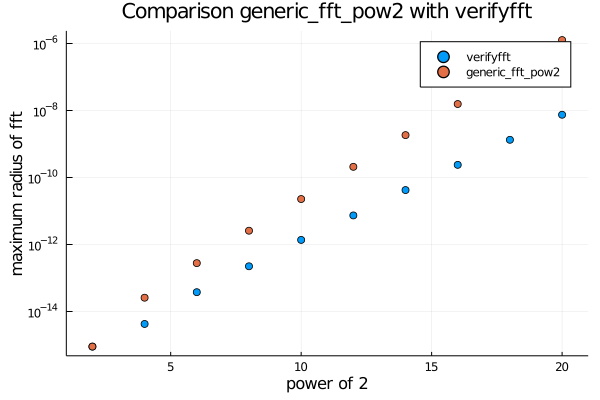

In [57]:
using Plots
index = 2:2:20
max_rad1 = zeros(size(index))
max_rad2 = zeros(size(index))
i = 1
for n ∈ index
    a = map(Interval, randn(2^n))

    z1 = verifyfft(a)
    z2 = generic_fft_pow2(a)

    max_rad1[i] = sup(maximum(radius,z1))
    max_rad2[i] = sup(maximum(radius,z2))

    i += 1
end
max_rad1
plot(index, max_rad1, yscale=:log10,
    xlabel       = "power of 2",                #X軸のラベル
    ylabel       = "maximum radius of fft",   #Y軸のラベル
    xlims        =(1,21),             #X軸の範囲
    title="Comparison generic_fft_pow2 with verifyfft",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに
    size         =(600,400),          #プロットのサイズ
    label = "verifyfft",#凡例のラベル
    legend = false,                   #凡例は今回は消す   
)

plot!(index, max_rad2, yscale=:log10,
#     xlabel       ="2^n",                #X軸のラベル
#     ylabel       ="maximum radius of fft",   #Y軸のラベル
#     xlims        =(1,21),             #X軸の範囲
#     title="Comparison generic_fft_pow2 with verifyfft",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
#     size         =(400,300),          #プロットのサイズ
    label = "generic_fft_pow2",#凡例のラベル
    legend = true,                   #凡例は今回は消す
)



```
plot(index, max_rad1, yscale=:log10,
    xlabel       ="power of 2",                #X軸のラベル
    ylabel       ="maximum radius of fft",   #Y軸のラベル
    xlims        =(1,21),             #X軸の範囲
    title="Comparison generic_fft_pow2 with verifyfft",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    size         =(600,400),          #プロットのサイズ
#     label = "without pre-conditioned",#凡例のラベル
    legend = false,                   #凡例は今回は消す
)
plot!(index, max_rad2, yscale=:log10,
#     xlabel       ="2^n",                #X軸のラベル
#     ylabel       ="maximum radius of fft",   #Y軸のラベル
#     xlims        =(1,21),             #X軸の範囲
#     title="Comparison generic_fft_pow2 with verifyfft",       #タイトル
#     linewidth    =2,                  #線幅
#     seriestype = :scatter,            #点プロットに　
#     size         =(400,300),          #プロットのサイズ
# #     label = "without pre-conditioned",#凡例のラベル
#     legend = false,                   #凡例は今回は消す
)
```

今回実装を行ったものは全て1次元のFFTである。2次元のFFTの計算を行う場合は`verifyfft(verifyfft(A,1).',1).'`と計算を行えば良い。

### さらに早く計算するには
- 並列処理の設定を行う。export JULIA_NUM_THREADS=8などと、スレッド数を指定。
- planfftを利用し、inplace(計算機科学においてデータ構造の変換を行うにあたって、追加の記憶領域をほとんど使わずに行うアルゴリズム)を行う。
- Juiaでも、MATLABと同じくMLKを使用する。

下のコードはMATLABのverifyfftのコード

function Z = verifyfft(z,sign)
%VERIFYFFT    Verified forward and backward 1-dimensional FFT
%
%   res = verifyfft(z,sign)
%
%   z     input vector or matrix
%         length of z must be a power of 2 
%   sign   1 forward FFT (default)
%         -1 inverse FFT
% 
%As in Matlab, the inverse FFT is scaled such that forward and inverse FFT
%are inverse operations.
%For matrix input, FFT is performed on each column; row vector input
%is converted into column vector. 
%For N-dimensional FFT apply verifyfft N times.
% 

% written  09/24/14     S.M. Rump  (based no Marcio Gameiro's code)
% modified 01/16/16     S.M. Rump  improved error estimates
%

% data generated by fft_data_gen
%

  global INTLAB_CONST
  
  [n,col] = size(z);
  if n==1
    if col==1
      Z = intval(z);
      return
    else
      isrow = 1;
      z = z(:);
      n = col;
      col = 1;
    end
  else
    isrow = 0;
  end
    
  if nargin==1
    sign = 1;       % default: forward
  end
  
  % check dimension
  log2n = round(log2(n));
  if 2^log2n~=n
    error('length must be power of 2')
  end
  
  % bit-reversal
  % v = bin2dec(fliplr(dec2bin(0:n-1,log2n))) + 1
  f = 2^(log2n-1);
  v = [0;f]; 
  for k=1:log2n-1
    f = 0.5*f;
    v = [ v ; f+v ];
  end
  z = z(v+1,:);
  
  % Danielson-Lanczos algorithm
  Z = intval(z);
  Index = reshape(1:n*col,n,col);
  nmax = INTLAB_CONST.FFTDATA_NMAX; % maximum in fft_data
  if n<=nmax
    r = INTLAB_CONST.FFTDATA_R;     % roots of unity in  r +/- d
    d = INTLAB_CONST.FFTDATA_D(log2n);
    Phi = midrad(r(1:nmax/n:nmax),d);
    if sign==-1
      Phi = (Phi.')';      
    end
  else
    % compute roots of unity, division exact because n is power of 2
    theta = intval('pi') * ( sign*(0:(n-1))'/n ); 
    Phi = cos(theta) + 1i*sin(theta);
  end
  v = 1:2:n;
  w = 2:2:n;
  t = Z(w,:);
  Z(w,:) = Z(v,:) - t;
  Z(v,:) = Z(v,:) + t;
  
  for index=1:(log2n-1)     % Executed log2(n) times
    m = 2^index;
    m2 = 2*m;
    vw = reshape(1:n,m2,n/m2);
    v = vw(1:m,:);
    w = vw(m+1:m2,:);
%     t = bsxfun(@times,exp(1i*pi*(0:m-1)'/m),Z(w));  % doesn't work for intervals
%     theta = intval('pi') * (sign*(0:(m-1))'/m);     % division exact because m=2^p
%     t = exp(1i*theta) .* Z(w);
    indexv = reshape(Index(v(:),:),m,col*n/m2);
    indexw = reshape(Index(w(:),:),m,col*n/m2);
%     t = repmat(Phi(1:n/m:end),1,n/m2*col);
    t = Phi(1:n/m:end,ones(1,n/m2*col)) .* Z(indexw);   % Tony's trick
    Z(indexw) = Z(indexv) - t;
    Z(indexv) = Z(indexv) + t;
  end
  
  Z = [Z(1,:); flipud(Z(2:end,:))];
  if sign==-1
    Z = Z/n;        % error-free since n is a power of 2
  end
  
  if isrow          % change to row vector
    Z = transpose(Z);
  end
  
end


L. R. Rabiner, R. W. Schafer, and C. M. Rader, ``The chirp z-transform algorithm and its application,'' Bell System Technical Journal, vol. 48, pp. 1249-1292, 1969,
also published in IEEE Tr. Audio & Electroacoustics, vol. 17, no. 2, pp. 86-92, 1969.

1. James W. Cooley and John W. Tukey, An algorithm for the machine calculation of complex Fourier series, Mathematics of Computation, 19 (1965), 297-301.
1. 